# 1.导入特征工程后的数据

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_csv("train_4.csv",nrows= 3000,index_col=0)   #拿50万条数据训练
train.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,C15,C16,C17,C18,C19,C20,C21,hour_hours,hour_weekday,hour_days
0,0,0,0,1,1,2,0,0,0,-1,...,0,0,0,0,0,0,2,0,2,0
1,0,0,0,1,1,2,0,0,0,11,...,0,0,0,0,0,1,2,0,2,0
2,0,0,0,1,1,2,0,0,0,0,...,0,0,0,0,0,1,2,0,2,0
3,0,0,0,1,1,2,0,0,0,43,...,0,0,0,0,0,1,2,0,2,0
4,0,0,1,-1,-1,-1,0,0,0,22,...,0,0,113,0,0,0,6,0,2,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 23 columns):
click               3000 non-null int64
C1                  3000 non-null int64
banner_pos          3000 non-null int64
site_id             3000 non-null int64
site_domain         3000 non-null int64
site_category       3000 non-null int64
app_id              3000 non-null int64
app_domain          3000 non-null int64
app_category        3000 non-null int64
device_model        3000 non-null int64
device_type         3000 non-null int64
device_conn_type    3000 non-null int64
C14                 3000 non-null int64
C15                 3000 non-null int64
C16                 3000 non-null int64
C17                 3000 non-null int64
C18                 3000 non-null int64
C19                 3000 non-null int64
C20                 3000 non-null int64
C21                 3000 non-null int64
hour_hours          3000 non-null int64
hour_weekday        3000 non-null int64
hour_days    

# 2.GBDT模型

In [5]:
y = train['click']
x = train.drop(["click"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [6]:
# 定义模型
xgboost = xgb.XGBClassifier(nthread=4, learning_rate=0.08,
                        n_estimators=20, max_depth=2, gamma=0, subsample=0.5, colsample_bytree=0.7)
# 训练学习
xgboost.fit(x_train, y_train)


# 预测及logloss评测
y_pred_gbdt = xgboost.predict_proba(x_test)
logloss_gbdt = log_loss(y_test, y_pred_gbdt)
print ("test logloss of GBDT  :",logloss_gbdt )

fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_pred_gbdt[:,1])

test logloss of GBDT  : 0.4336803011596203


In [7]:
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_pred_gbdt[:,1])

### 用训练好GBDT，对原始特征编码

In [8]:
# xgboost编码原有特征。变为【数据条数:树的数目】
#如果用gbdt(GradientBoostingClassifier)，apply()的结果是三维的,[数据条数:树的数目:叶子节点数]x_train_leaves = xgboost.apply(x_train)[:,:,0]
x_train_leaves = xgboost.apply(x_train)     
x_test_leaves = xgboost.apply(x_test) 

print("训练集编码后size:",x_train_leaves.shape)
print("验证集编码后size:",x_test_leaves.shape)

训练集编码后size: (2100, 20)
验证集编码后size: (900, 20)


# 3.数据预处理

由于自己实现的FFM模型,参数指定是dataFrame，这里需要先转换格式

In [9]:
#ndarray 转dataFrame
x_train_leaves = pd.DataFrame(x_train_leaves)            
x_test_leaves = pd.DataFrame(x_test_leaves)
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

调用预处理方法,one_hot，同时得到ffm_dic字典

In [10]:
import ffm_data_process                #FFM前的数据预处理(内含one-hot)

x_train,x_test,feature_n,filed_m,ffm_dic = ffm_data_process.onehot_get_dict(x_train_leaves,x_test_leaves)
# del x_train_leaves,x_test_leaves
print("训练集onehot后size:",x_train.shape)
print("验证集onehot后size:",x_test.shape)
print(type(x_train))

训练集onehot后size: (2100, 80)
验证集onehot后size: (900, 80)
<class 'pandas.core.frame.DataFrame'>


# 4.GBDT+LR:

In [11]:
from sklearn.linear_model import LogisticRegression
# 定义LR模型
lr = LogisticRegression(n_jobs = -1, C=0.1, penalty='l1',solver='liblinear')
# lr对gbdt特征编码后的样本模型训练
lr.fit(x_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
# 预测及LogLoss评测
y_pred_lr = lr.predict_proba(x_test)
logloss = log_loss(y_test, y_pred_lr)
print('LogLoss:' , logloss)

LogLoss: 0.40835707116546777


In [13]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr[:,1])

# 5.GBDT+FTRL

In [32]:
import FTRL
d = x_train.shape[1] 
ftrl = FTRL.FTRL(dim=d, l1=0.01, l2=0.01, alpha=0.08, beta=1.0)
start = time.time()
ftrl.train(x_train, y_train, min_loss=0.01, epochs=5,early_stop = 100,print_loss = True)
end = time.time()
print("time:",str(end-start))

epoch: 0 i= 0	loss=0.6931471805599453
epoch: 0 i= 500	loss=0.4045771321943643
epoch: 0 i= 1000	loss=0.07185249017502504
epoch: 0 i= 1500	loss=0.06828153434983945
epoch: 0 i= 2000	loss=0.07474042737092866
epoch: 1 i= 0	loss=0.0812166737835196
epoch: 1 i= 500	loss=0.3529765289959689
epoch: 1 i= 1000	loss=0.058696473553055746
epoch: 1 i= 1500	loss=0.07565438173572854
epoch: 1 i= 2000	loss=0.07534510460059
epoch: 2 i= 0	loss=0.08410749364629129
epoch: 2 i= 500	loss=0.33209414774625656
epoch: 2 i= 1000	loss=0.0566121848102279
epoch: 2 i= 1500	loss=0.07834759712650236
epoch: 2 i= 2000	loss=0.07529840882254107
epoch: 3 i= 0	loss=0.08633552483655055
epoch: 3 i= 500	loss=0.319674267457581
epoch: 3 i= 1000	loss=0.05625948351590896
epoch: 3 i= 1500	loss=0.08005885888079328
epoch: 3 i= 2000	loss=0.07521896849388567
epoch: 4 i= 0	loss=0.08826297534714939
epoch: 4 i= 500	loss=0.3111714455854042
epoch: 4 i= 1000	loss=0.05639203956116984
epoch: 4 i= 1500	loss=0.08136558727942926
epoch: 4 i= 2000	loss=

In [33]:
y_pred_ftrl = ftrl.predict(x_test)
logloss_ftrl = log_loss(y_test, y_pred_ftrl)
print ("test logloss of FTRL  :",logloss_ftrl )

test logloss of FTRL  : 0.4046678317481171


In [16]:
fpr_ftrl, tpr_ftrl, _ = roc_curve(y_test, y_pred_ftrl)

# 6.GBDT+FFM

FFM的时间复杂度O(KD²)，训练很慢

In [ ]:
from FFM import FFMClassifier  
import time
k = 4
eta = 0.2
lambd = 2e-5
max_echo = 6   
min_loss =0.2
ffm = FFMClassifier(feature_n, filed_m , k , eta , lambd , ffm_dic )
start = time.time()
ffm.train(x_train , y_train, max_echo , min_loss)
end = time.time()
print("time:",str(end-start))

epoch: 0,第: 0 条数据训练
epoch: 0,第: 500 条数据训练
epoch: 0,第: 1000 条数据训练
epoch: 0,第: 1500 条数据训练
epoch: 0,第: 2000 条数据训练
epoch: 0, train_loss: 0.4579894520861596
epoch: 1,第: 0 条数据训练
epoch: 1,第: 500 条数据训练
epoch: 1,第: 1000 条数据训练
epoch: 1,第: 1500 条数据训练
epoch: 1,第: 2000 条数据训练
epoch: 1, train_loss: 0.45563783625888205
epoch: 2,第: 0 条数据训练
epoch: 2,第: 500 条数据训练
epoch: 2,第: 1000 条数据训练
epoch: 2,第: 1500 条数据训练


In [40]:
y_pred_ffm = ffm.predict(x_test)
logloss_ffm = log_loss(y_test,y_pred_ffm)
print ("test logloss of FFM  :",logloss_ffm )

test logloss of FFM  : 0.44843363466388036


In [41]:
fpr_ffm, tpr_ffm, _ = roc_curve(y_test, y_pred_ffm)

# 7.图形展示

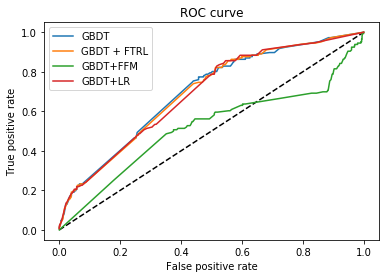

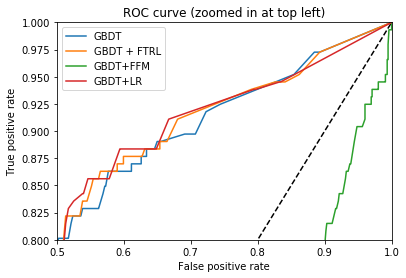

In [42]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gbdt, tpr_gbdt, label='GBDT')
plt.plot(fpr_ftrl, tpr_ftrl, label='GBDT + FTRL')
plt.plot(fpr_ffm, tpr_ffm, label='GBDT+FFM')
plt.plot(fpr_lr, tpr_lr, label='GBDT+LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.5, 1.0)
plt.ylim(0.8, 1.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gbdt, tpr_gbdt, label='GBDT')
plt.plot(fpr_ftrl, tpr_ftrl, label='GBDT + FTRL')
plt.plot(fpr_ffm, tpr_ffm, label='GBDT+FFM')
plt.plot(fpr_lr, tpr_lr, label='GBDT+LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()